In [1]:
import torch
from torchsummary import summary
from CNN import CNN
from FC import FC
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# mnist dataset
dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn = CNN().to(DEVICE)
summary(cnn, (1, 28, 28))
cnn.weight_init()

train_size = int(0.6 * len(dataset))
val_size = len(dataset) - train_size

training_set, validation_set = random_split(dataset, [train_size, val_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
         MaxPool2d-3            [-1, 4, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              ReLU-8             [-1, 16, 7, 7]               0
         MaxPool2d-9             [-1, 16, 3, 3]               0
          Flatten-10                  [-1, 144]               0
           Linear-11                   [-1, 10]           1,450
          Softmax-12                   [-1, 10]               0
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
-----------------------------------

In [3]:
epochs = 10
batch_size = 32

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [4]:
cnn_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

for epoch in range(epochs):
    cum_loss = 0
    print(f"Epoch {epoch + 1}\n-------------------------------")
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Backward and optimize
        optimizer.zero_grad()
        # Forward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        cum_loss += loss.item()
        # Backward and optimize
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Loss: {cum_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    cnn_df = pd.concat([cnn_df, pd.DataFrame([[epoch + 1, cum_loss / len(train_loader), 100 * correct / total]],
                                             columns=['epoch', 'loss', 'accuracy'])])
cnn_df.to_csv('cnn.csv', index=False)

Epoch 1
-------------------------------
Loss: 1.6532, Accuracy: 93.14%
Epoch 2
-------------------------------
Loss: 1.5225, Accuracy: 95.08%
Epoch 3
-------------------------------
Loss: 1.5077, Accuracy: 95.62%
Epoch 4
-------------------------------
Loss: 1.5007, Accuracy: 95.89%
Epoch 5
-------------------------------
Loss: 1.4985, Accuracy: 96.95%
Epoch 6
-------------------------------
Loss: 1.4933, Accuracy: 96.75%
Epoch 7
-------------------------------
Loss: 1.4921, Accuracy: 96.49%
Epoch 8
-------------------------------
Loss: 1.4910, Accuracy: 97.20%
Epoch 9
-------------------------------
Loss: 1.4892, Accuracy: 96.97%
Epoch 10
-------------------------------
Loss: 1.4874, Accuracy: 97.35%


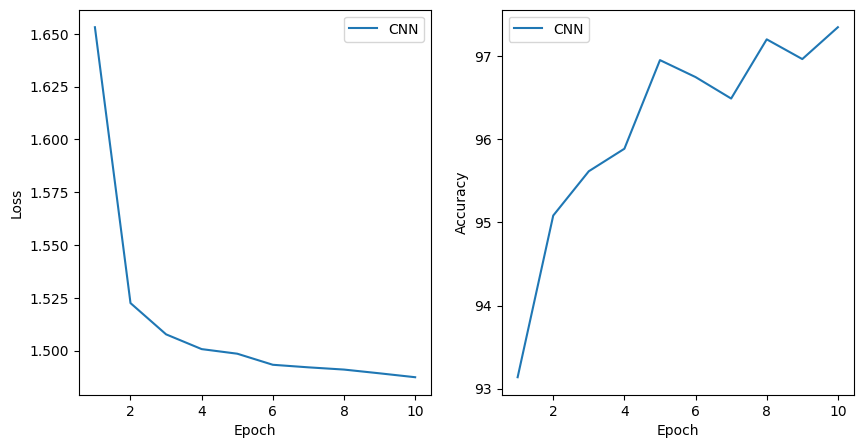

  epoch      loss   accuracy
0     1  1.653152  93.137500
0     2  1.522483  95.083333
0     3  1.507678  95.616667
0     4  1.500686  95.887500
0     5  1.498511  96.954167
0     6  1.493265  96.750000
0     7  1.492051  96.491667
0     8  1.490994  97.204167
0     9  1.489218  96.966667
0    10  1.487370  97.350000


In [5]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_df['epoch'], cnn_df['loss'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(cnn_df['epoch'], cnn_df['accuracy'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(cnn_df)

In [2]:
dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fc = FC().to(DEVICE)
summary(fc, (1, 28, 28))
fc.weight_init()

train_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size

training_set, validation_set = random_split(dataset, [train_size, val_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 10]             330
           Softmax-4                   [-1, 10]               0
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [3]:
epochs = 10
batch_size = 32

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [4]:
fc_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

for epoch in range(epochs):
    cum_loss = 0
    print(f"Epoch {epoch + 1}\n-------------------------------")
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Backward and optimize
        optimizer.zero_grad()
        # Forward pass
        outputs = fc(images)
        loss = criterion(outputs, labels)
        cum_loss += loss.item()
        # Backward and optimize
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = fc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Loss: {cum_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    fc_df = pd.concat([fc_df, pd.DataFrame([[epoch + 1, cum_loss / len(train_loader), 100 * correct / total]],
                                             columns=['epoch', 'loss', 'accuracy'])])
fc_df.to_csv('fc.csv', index=False)

Epoch 1
-------------------------------
Loss: 1.6917, Accuracy: 89.75%
Epoch 2
-------------------------------
Loss: 1.5717, Accuracy: 91.05%
Epoch 3
-------------------------------
Loss: 1.5539, Accuracy: 91.67%
Epoch 4
-------------------------------
Loss: 1.5435, Accuracy: 91.83%
Epoch 5
-------------------------------
Loss: 1.5355, Accuracy: 92.52%
Epoch 6
-------------------------------
Loss: 1.5292, Accuracy: 92.59%
Epoch 7
-------------------------------
Loss: 1.5230, Accuracy: 93.30%
Epoch 8
-------------------------------
Loss: 1.5179, Accuracy: 93.37%
Epoch 9
-------------------------------
Loss: 1.5150, Accuracy: 93.21%
Epoch 10
-------------------------------
Loss: 1.5100, Accuracy: 93.85%


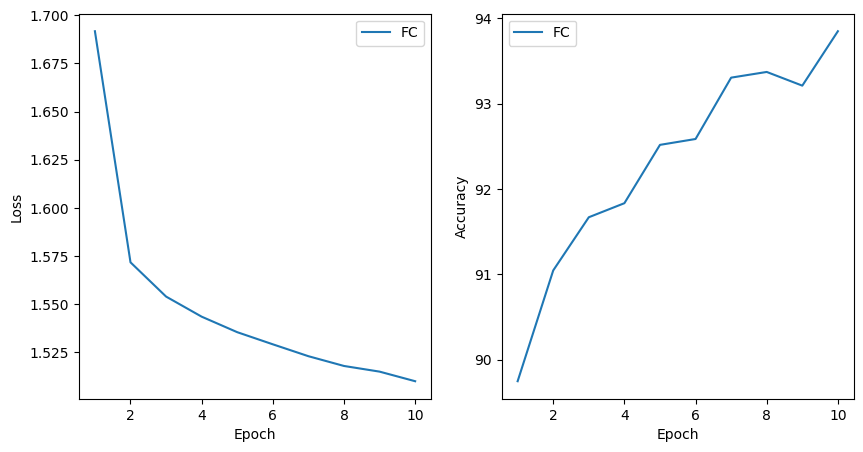

   epoch      loss   accuracy
0      1  1.691734  89.747917
1      2  1.571726  91.045833
2      3  1.553944  91.668750
3      4  1.543511  91.833333
4      5  1.535454  92.516667
5      6  1.529157  92.585417
6      7  1.522983  93.304167
7      8  1.517913  93.370833
8      9  1.514972  93.210417
9     10  1.509992  93.847917


In [8]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['loss'], label='FC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fc_df['epoch'], fc_df['accuracy'], label='FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(fc_df)

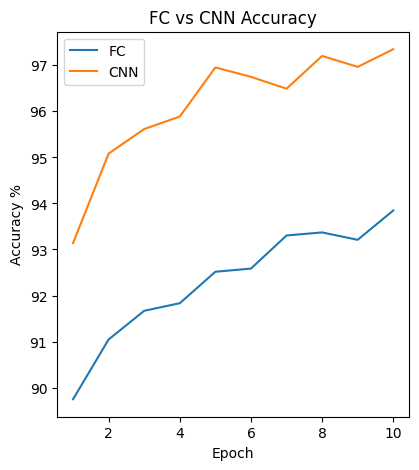

In [11]:
# plot fcc and cnn accuracy
fc_df = pd.read_csv('fc.csv')
cnn_df = pd.read_csv('cnn.csv')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['accuracy'], label='FC')
plt.plot(cnn_df['epoch'], cnn_df['accuracy'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('FC vs CNN Accuracy')

plt.savefig('fc_vs_cnn_accuracy.png')

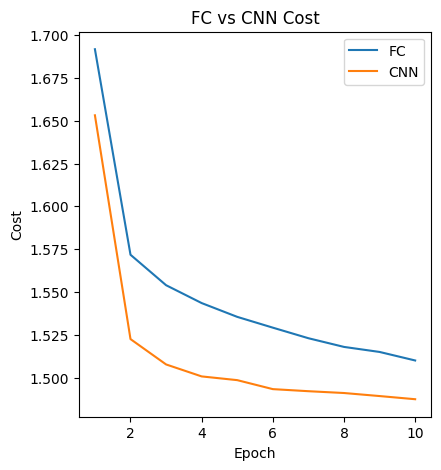

In [12]:
# plot fcc and cnn accuracy
fc_df = pd.read_csv('fc.csv')
cnn_df = pd.read_csv('cnn.csv')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['loss'], label='FC')
plt.plot(cnn_df['epoch'], cnn_df['loss'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.title('FC vs CNN Cost')

plt.savefig('fc_vs_cnn_cost.png')